In [1]:
import os, sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]=""
import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib
import tensorflow.contrib.immediate as immediate

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 bus_adjacency: BUS_ANY
 incarnation: 3112931853206047956, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 706207744
 incarnation: 14688010904910914127
 physical_device_desc: "device: 0, name: GeForce GT 650M, pci bus id: 0000:01:00.0"]

# Reproduce Torch gradient descent

## Convert MNIST csv data to numpy

In [4]:
data = np.loadtxt("mnist.t7/test_32x32.t7.csv.data", dtype=np.uint8).reshape(10000, 32, 32)
np.save("mnist.t7/test_32x32.npy", data)

In [6]:
data = np.loadtxt("mnist.t7/train_32x32.t7.csv.data", dtype=np.uint8).reshape(60000, 32, 32)
np.save("mnist.t7/train_32x32.npy", data)

In [130]:
data = np.loadtxt("mnist.t7/train_32x32.t7.csv.labels", dtype=np.uint8)
np.save("mnist.t7/train_labels.npy", data)

In [9]:
data = np.loadtxt("mnist.t7/test_32x32.t7.csv.labels", dtype=np.uint8)
np.save("mnist.t7/test_labels.npy", data)

In [126]:
data = np.load("mnist.t7/train_32x32.npy")

In [128]:
np.save("mnist.t7/train_32x32_small.npy", data[:100])

In [131]:
data = np.load("mnist.t7/train_labels.npy")
np.save("mnist.t7/train_labels_small.npy", data[:100])

In [132]:
config=tf.ConfigProto()

In [ ]:
config.inter_op_parallelism_threads

### Save first 100 examples

## Reproduce loss on first example

In [11]:
train_data = np.load("mnist.t7/train_32x32.npy")

In [47]:
train_labels = np.load("mnist.t7/train_labels.npy")

In [32]:
env = immediate.Env(tf)
tfi = env.tf

In [74]:
i = 0
W = tfi.ones((10, 1024), dtype=tf.float32)
b = tfi.ones((10, 1), dtype=tf.float32)
x = env.numpy_to_itensor(train_data[i], dtype=tf.float32)
x_flat = tfi.reshape(x, (1024, 1))
logits = tfi.matmul(W, x_flat)+b
targets = tfi.one_hot(train_labels[i]-1, 10)  # Lua labels are off-by-one
targets = tfi.reshape(targets, (1, 10))
logits = tfi.reshape(logits, (1, 10))
cross_entropy = tfi.nn.softmax_cross_entropy_with_logits(logits, targets)

In [75]:
cross_entropy

ITensor([ 2.30258512], dtype=float32)

## Reproduce gradient on first example

In [77]:
lua_grad = np.loadtxt("first_grad.csv", dtype=np.float32)

In [125]:
tfi.reduce_sum(lua_grad)

ITensor(0.0186698, dtype=float32)

In [129]:
lua_grad.shape

(10250,)

In [133]:
lua_grad[-10:]

array([ 0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
       -0.89999998,  0.1       ,  0.1       ,  0.1       ,  0.1       ], dtype=float32)

### Get gradients in TensorFlow

In [855]:
dtype = tf.float64
W = tf.Variable(tf.ones_initializer((10, 1024), dtype=dtype))
b = tf.Variable(tf.ones_initializer((10, 1), dtype=dtype))
x = tf.constant(train_data[i], dtype=dtype)
x_flat = tf.reshape(x, (1024, 1))
logits = tf.matmul(W, x_flat)+b
targets = tf.one_hot(train_labels[i]-1, 10, dtype=dtype)  # Lua labels are off-by-one
targets = tf.reshape(targets, (1, 10))
logits = tf.reshape(logits, (1, 10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, targets)
gradients = tf.gradients(cross_entropy, [W, b])

In [157]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [156]:
sess.run(gradients[1])

array([[ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [-0.9],
       [ 0.1],
       [ 0.1]])

In [149]:
sess.run(targets)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

In [150]:
train_labels[0]

6

## Get gradients/parameters from Lua

In [9]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata.sgd/grad-"+str(i)
    param_fname = "stepdata.sgd/params-"+str(i)
    fval_fname = "stepdata.sgd/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))

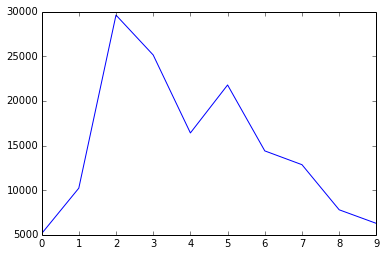

In [10]:
plt.plot(lua_fvals)

In [94]:
lua_params[0]+lua_grads[0]

array([ 2.  ,  2.  ,  2.  , ...,  2.  ,  2.02,  1.99])

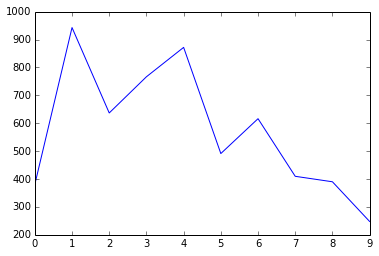

In [484]:
plt.plot([np.linalg.norm(x) for x in lua_grads])

## Reproduce MNIST sgd

In [4]:
train_data = np.load("mnist.t7/train_32x32.npy")
train_data_flat = train_data.reshape((-1, 1024))
train_labels = np.load("mnist.t7/train_labels.npy")
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [5]:
def concat_flatten(tensors):
    """Flattens tensors, concats them"""
    flat_tensors = []
    for tensor in tensors:
        flat_tensors.append(tf.reshape(tensor, [-1]))
    return tf.concat(0, flat_tensors)

In [6]:
dtype = tf.float64
batchSize = 100
learningRate = 0.1

tf.reset_default_graph()

W = tf.Variable(tf.ones_initializer((1024, 10), dtype=dtype))
b = tf.Variable(tf.ones_initializer((1, 10), dtype=dtype))
x = tf.Variable(tf.zeros_initializer((batchSize, 1024), dtype=dtype))
targets = tf.Variable(tf.zeros_initializer((batchSize, 10), dtype=dtype))
logits = tf.matmul(x, W) + b

# cross entropy expects batch dimension to be first, transpose inputs
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, targets)
cross_entropy_loss = tf.reduce_mean(cross_entropy)
Wnorm = tf.reduce_sum(tf.square(W))
bnorm = tf.reduce_sum(tf.square(b))
loss = cross_entropy_loss + (bnorm + Wnorm)/2

# grads = tf.gradients(loss, [W, b])
opt = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
grads_and_vars = opt.compute_gradients(loss, [W, b])
train_step = opt.apply_gradients(grads_and_vars)

W_grad = grads_and_vars[0][0]
b_grad = grads_and_vars[1][0]
flat_grad = concat_flatten([tf.transpose(W_grad), b_grad])
# flat_grad = concat_flatten([grad_and_var[0] for grad_and_var in grads_and_vars])
flat_params = concat_flatten([tf.transpose(W), b])

# initialize x and targets
x_placeholder = tf.placeholder(dtype=dtype)
x_init = x.assign(x_placeholder)

# initialize labels
labels_placeholder = tf.placeholder(shape=(batchSize), dtype=tf.int32)
labels_onehot = tf.one_hot(labels_placeholder - 1, 10, dtype=dtype)  # Lua labels are off-by-one
targets_init = targets.assign(labels_onehot)

sess = tf.InteractiveSession()
sess.run(x_init, feed_dict={x_placeholder:train_data_flat[:batchSize]})
sess.run(targets_init, feed_dict={labels_placeholder: train_labels[:batchSize]})
sess.run([W.initializer, b.initializer])
print(sess.run(loss))

5127.30258509


In [553]:
tf_grads = []
tf_params = []
tf_fvals = []
for i in range(10):
    tf_grads.append(sess.run(flat_grad))
    tf_params.append(sess.run(flat_params))
    tf_fvals.append(sess.run(loss))
    print(tf_fvals[-1])
    sess.run(train_step)

5127.30258509
10222.2878245
29610.151198
25141.4119371
16409.1374003
21781.9665362
14398.5814516
12851.5786807
7800.24671143
6276.07440723


In [11]:
lua_grads[0]

array([ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.02,  0.99])

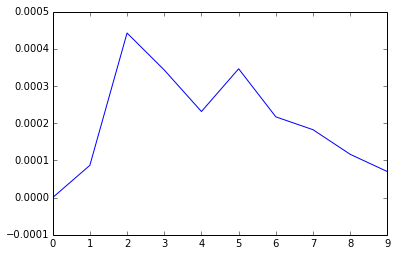

In [543]:
tf_fvals_np = np.array(tf_fvals)
lua_fvals_np = np.array(lua_fvals)
plt.plot(tf_fvals_np - lua_fvals_np)

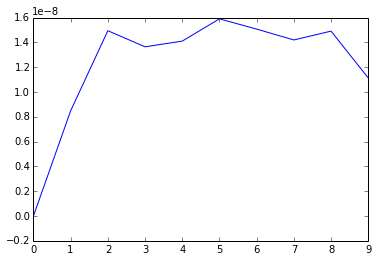

In [544]:
plt.plot((tf_fvals_np - lua_fvals_np)/lua_fvals_np)

### Feed lua params back into TensorFlow

Get the values from Lua, feed them into TensorFlow to get updated grad value

In [577]:
iternum = 1
# convert lua_W from column major to row major
lua_W_flat = lua_params[iternum][:-10]
lua_W = lua_W_flat.reshape((10, 1024))
tf_W = lua_W.T
lua_b = lua_params[iternum][-10:]
tf_b = lua_b.reshape((1, -1))

In [578]:
sess.run(loss, feed_dict={W: tf_W, b: tf_b})

10222.287737750139

In [16]:
np.array([[1,2,3],[4,5,6]]).reshape(-1)

array([1, 2, 3, 4, 5, 6])

# Reproduce Torch l-BFGS

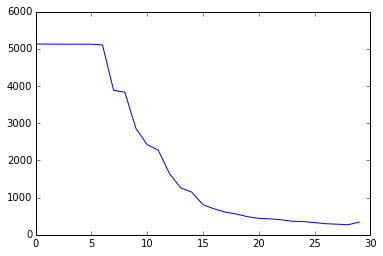

In [582]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

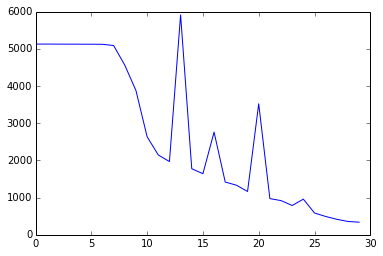

In [583]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

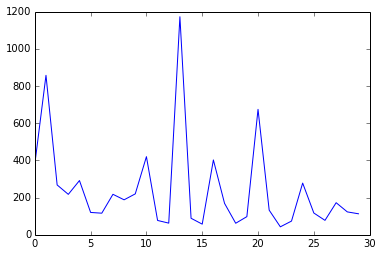

In [585]:
plt.plot([np.linalg.norm(g) for g in lua_grads])

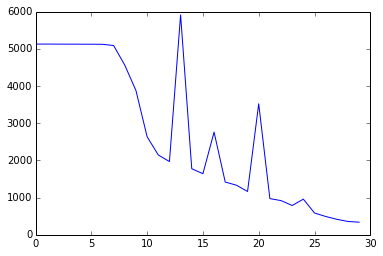

In [590]:
#lua_grads = []
#lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
#    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(fval_fname):
        break
#    lua_grads.append(np.loadtxt(grad_fname))
#    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

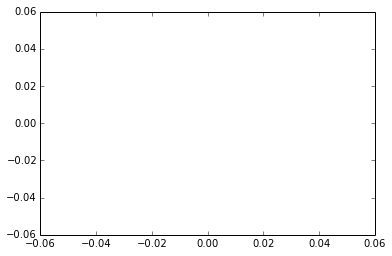

In [50]:
#lua_grads = []
#lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata.lbfgs/grad-"+str(i)
#    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata.lbfgs/fval-"+str(i)
    if not os.path.exists(fval_fname):
        break
#    lua_grads.append(np.loadtxt(grad_fname))
#    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))
plt.plot(lua_fvals)

In [48]:
lua_fvals

[array(5127.302585093),
 array(10222.28773775),
 array(29610.150755578),
 array(25141.411594117),
 array(16409.137168876),
 array(21781.966189939),
 array(14398.581234542),
 array(12851.578498288),
 array(7800.2465951378),
 array(6276.0743373525)]

## Load intermediate values

In [51]:
class Step(object):
    pass

def tryload(fname):
    if os.path.exists(fname):
        return np.loadtxt(fname, dtype=np.float64)
    else:
        return None
    
def loadStep(i):
    step = Step()
    step.al = tryload("stepdata/al-"+str(i))
    step.q = tryload("stepdata/q-"+str(i))
    step.ro = tryload("stepdata/ro-"+str(i))
    step.g = tryload("stepdata/g-"+str(i))
    step.x = tryload("stepdata/x-"+str(i))
    step.f = tryload("stepdata/f-"+str(i))
    step.Hdiag = tryload("stepdata/Hdiag-"+str(i))
    step.d = tryload("stepdata/d-"+str(i))
    step.be_i = tryload("stepdata/be_i-"+str(i))
    step.r = tryload("stepdata/r-"+str(i))
    step.y = tryload("stepdata/y-"+str(i))
    step.s = tryload("stepdata/s-"+str(i))
    step.tmp1 = tryload("stepdata/tmp1-"+str(i))
    step.tmp11 = tryload("stepdata/tmp11-"+str(i))
    step.ys = tryload("stepdata/ys-"+str(i))
    step.gtd = tryload("stepdata/gtd-"+str(i))
    step.t = tryload("stepdata/t-"+str(i))
    step.fdiff = tryload("stepdata/fdiff-"+str(i))
    return step

In [23]:
steps = [loadStep(i) for i in range(0, 30)]

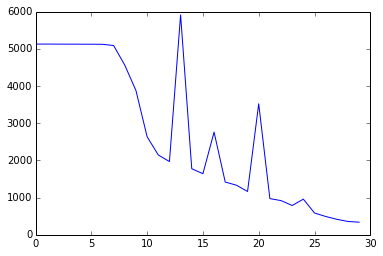

In [52]:
plt.plot([step.f for step in steps])

In [53]:
[step.f for step in steps]

[array(5127.302585093),
 array(5127.0317186252),
 array(5125.3903813101),
 array(5124.9674848028),
 array(5123.9669985619),
 array(5123.0994629498),
 array(5121.1336109133),
 array(5088.2182634182),
 array(4560.4319275404),
 array(3878.0882110897),
 array(2636.9614862181),
 array(2145.9010199365),
 array(1969.3409923076),
 array(5911.8849327637),
 array(1776.60222906),
 array(1642.2119970127),
 array(2760.5909104183),
 array(1417.8663532243),
 array(1334.1882656872),
 array(1164.8566400448),
 array(3521.6275053109),
 array(973.35657880749),
 array(919.30050246557),
 array(787.88005184536),
 array(958.20801923218),
 array(585.85990525397),
 array(492.62865981719),
 array(416.67239837961),
 array(358.67124865516),
 array(339.26098729848)]

## Reproduce in numpy

In [689]:
def maxdiff(a, b):
    return np.max((a-b)/b)

In [691]:
def RelativeError(new_val, reference_val, atol = 2.**-53):
  return np.max(np.abs(new_val - reference_val) / (atol + np.abs(reference_val)))

In [28]:
from numpy.testing.utils import nulp_diff
def ulp_diff(a, b):
    try:
        return max(nulp_diff(a.astype(np.float32), b.astype(np.float32)))
    except:
        return nulp_diff(a.astype(np.float32), b.astype(np.float32))

In [29]:
def check(a, b, msg):
    diff = ulp_diff(np.asarray(a), np.asarray(b))
    if diff>0:
        print("%s %f"%(msg, diff))
    else:
        print("%s OK"%(msg))
        
old_dirs = []
old_stps = []
nCorrection = 100
ro = np.zeros((nCorrection,), dtype=np.float64)
al = np.zeros((nCorrection,), dtype=np.float64)

# step 0
learningRate = 1.
x = steps[0].x
g = steps[0].g
f = steps[0].f

# step 1
ii=1
d = -g
check(steps[ii].d, d, "d")

f_old = f
g_old = g

gtd = np.dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

tmp1 = np.abs(np.array(g))
t = min(1, 1/tmp1.sum())
check(steps[ii].t, t, "t")

f = steps[ii].f
x = x + t*d
check(steps[ii].x, x, "x")
g = steps[ii].g

tmp1 = np.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

tmp11 = np.abs(d*t)
check(steps[ii].tmp11, tmp11, "tmp11")

check(steps[ii].fdiff, f-f_old, "fdiff")

# step 2
ii = 2
y = g - g_old
check(steps[ii].y, y, "y")
s = d*t
check(steps[ii].s, s, "s")

old_dirs.append(s)
old_stps.append(y)

ys = np.dot(y, s)
check(steps[ii].ys, ys, "ys")

Hdiag = ys/np.dot(y, y)
check(steps[ii].Hdiag, Hdiag, "Hdiag")


k = len(old_dirs)
for i in range(k):
    ro[i] = 1/old_stps[i].dot(old_dirs[i])
check(steps[ii].ro, ro, "ro")

q = -g
for i in range(k-1, -1, -1):
    al[i] = old_dirs[i].dot(q) * ro[i]
    q = q - al[i]*old_stps[i]
    
check(steps[ii].q, q, "q")
check(steps[ii].al, al, "al")

r = q*Hdiag
for i in range(k):
    be_i = old_stps[i].dot(r) * ro[i]
    r += (al[i]-be_i)*old_dirs[i]
d = r
    
check(steps[ii].d, d, "d")
check(steps[ii].r, r, "r")

g_old = g
f_old = f

gtd = np.dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

t = learningRate
check(steps[ii].t, t, "t")

x = x + t*d
check(steps[ii].x, x, "x")
f = steps[ii].f
g = steps[ii].g

tmp1 = np.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

check(steps[ii].fdiff, f - f_old, "fdiff")
#fdiff = steps[ii].f - steps[0].f
#check(steps[ii].fdiff, fdiff, "fdiff")


#gtd = g.dot(d)
#check(step)

d OK
gtd OK
t OK
x OK
tmp1 OK
tmp11 OK
fdiff OK
y OK
s OK
ys OK
Hdiag OK
ro OK
q OK
al OK
d OK
r OK
gtd OK
t OK
x OK
tmp1 OK
fdiff OK


## Reproduce in TensorFlow

In [30]:
from numpy.testing.utils import nulp_diff
def ulp_diff(a, b):
    try:
        return max(nulp_diff(a.astype(np.float32), b.astype(np.float32)))
    except:
        return nulp_diff(a.astype(np.float32), b.astype(np.float32))
    
def check(a, b, msg):
    b = b.as_numpy()
    diff = ulp_diff(np.asarray(a), np.asarray(b))
    if diff>10:
        print("%s %f"%(msg, diff))
    else:
        print("%s OK"%(msg))
        
def dot(a, b):
    return im.reduce_sum(a*b)

import tensorflow as tf
env = immediate.Env(tf)
im = env.tf

In [42]:
old_dirs = []
old_stps = []
nCorrection = 100
#ro = im.zeros((nCorrection,), dtype=im.float64)
ro = [0]*nCorrection
al = [0]*nCorrection
#al = im.zeros((nCorrection,), dtype=im.float64)


# step 0
learningRate = env.numpy_to_itensor(1., dtype=im.float64)
x = env.numpy_to_itensor(steps[0].x, dtype=im.float64)
g = env.numpy_to_itensor(steps[0].g, dtype=im.float64)
f = env.numpy_to_itensor(steps[0].f, dtype=im.float64)

# step 1
ii=1
d = -g
check(steps[ii].d, d, "d")

f_old = f
g_old = g

gtd = dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

tmp1 = im.abs(g)
t = min(1, im.div(1, im.reduce_sum(tmp1)))
check(steps[ii].t, t, "t")

f = env.numpy_to_itensor(steps[ii].f, dtype=im.float64)
x = x + t*d

saved_t = t
saved_d = d
saved_x1 = x
saved_tmp1 = tmp1
saved_g = g

check(steps[ii].x, x, "x")
g = env.numpy_to_itensor(steps[ii].g, dtype=im.float64)

tmp1 = im.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

tmp11 = im.abs(d*t)
check(steps[ii].tmp11, tmp11, "tmp11")
check(steps[ii].fdiff, f-f_old, "fdiff")

# step 2
ii = 2
y = g - g_old
check(steps[ii].y, y, "y")
s = d*t
check(steps[ii].s, s, "s")

old_dirs.append(s)
old_stps.append(y)

ys = dot(y, s)
check(steps[ii].ys, ys, "ys")

Hdiag = im.div(ys, dot(y, y))
check(steps[ii].Hdiag, Hdiag, "Hdiag")

k = len(old_dirs)
for i in range(k):
    ro[i] = im.div(1, dot(old_stps[i], old_dirs[i]))
    
check(steps[ii].ro, im.pack(ro), "ro")

q = -g
for i in range(k-1, -1, -1):
    al[i] = dot(old_dirs[i], q) * ro[i]
    q = q - al[i]*old_stps[i]

check(steps[ii].q, q, "q")
check(steps[ii].al, im.pack(al), "al")

r = q*Hdiag
for i in range(k):
    be_i = dot(old_stps[i], r) * ro[i]
    r += (al[i]-be_i)*old_dirs[i]
d = r

check(steps[ii].d, d, "d")
check(steps[ii].r, r, "r")

g_old = g
f_old = f

gtd = dot(g, d)
check(steps[ii].gtd, gtd, "gtd")

t = learningRate
check(steps[ii].t, t, "t")

x = x + t*d
saved_x2 = x
check(steps[ii].x, x, "x")

f = env.numpy_to_itensor(steps[ii].f, dtype=im.float64)
g = env.numpy_to_itensor(steps[ii].g, dtype=im.float64)

tmp1 = im.abs(g)
check(steps[ii].tmp1, tmp1, "tmp1")

check(steps[ii].fdiff, f - f_old, "fdiff")


d OK
gtd OK
t OK
x OK
tmp1 OK
tmp11 OK
fdiff OK
y OK
s OK
ys OK
Hdiag OK
ro OK
q OK
al OK
d OK
r OK
gtd OK
t OK
x OK
tmp1 OK
fdiff OK


## Compare against TensorFlow reference vals

In [55]:
tf_steps = np.load("stepdata.lbfgs/tf_steps.npy")

In [56]:
tf_steps

array([ 5127.03171863,  5130.04318512,  5127.98121174,  5124.8685638 ,
        5126.54166589,  5123.77601491,  5123.52657661,  5122.07118443,
        5116.12007034,  5102.09056498,  4843.9990814 ,  2789.97579214,
        4627.80266186,  3100.37620804,  2722.08568563,  2461.58765335,
        2362.2904514 ,  3731.44232302,  2285.97570329,  2214.3510978 ,
        2123.95700776,  2067.77738624,  1971.95403217,  1890.38364658,
        1832.80364492,  1743.91193572,  1622.14935961,  1539.20976905,
        1429.11247567,  1329.57881407,  1329.57881407])

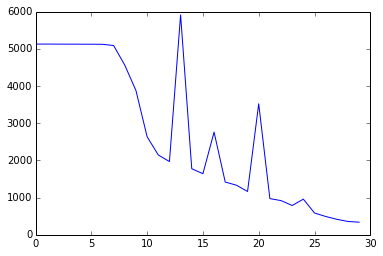

In [60]:
torch_steps = [step.f for step in steps]
plt.plot(torch_steps)

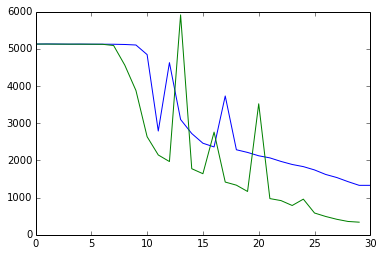

In [68]:
plt.plot(range(31), tf_steps, range(30), torch_steps)

In [150]:
class Step(object):
    pass

def load_txt(fname):
    if os.path.exists(fname):
        return np.loadtxt(fname, dtype=np.float64)
    else:
        return None
    
def load_binary(fname):
    fname = fname+".npy"  # numpy export adds suffix
    if os.path.exists(fname):
        return np.load(fname)
    else:
        return None
    
def loadStep(i, load_func, prefix):
    step = Step()
    step.al = load_func(prefix+"/al-"+str(i))
    step.q = load_func(prefix+"/q-"+str(i))
    step.ro = load_func(prefix+"/ro-"+str(i))
    step.g = load_func(prefix+"/g-"+str(i))
    step.x = load_func(prefix+"/x-"+str(i))
    step.f = load_func(prefix+"/f-"+str(i))
    step.Hdiag = load_func(prefix+"/Hdiag-"+str(i))
    step.d = load_func(prefix+"/d-"+str(i))
    step.be_i = load_func(prefix+"/be_i-"+str(i))
    step.r = load_func(prefix+"/r-"+str(i))
    step.y = load_func(prefix+"/y-"+str(i))
    step.s = load_func(prefix+"/s-"+str(i))
    step.tmp1 = load_func(prefix+"/tmp1-"+str(i))
    step.tmp11 = load_func(prefix+"/tmp11-"+str(i))
    step.ys = load_func(prefix+"/ys-"+str(i))
    step.gtd = load_func(prefix+"/gtd-"+str(i))
    step.t = load_func(prefix+"/t-"+str(i))
    step.fdiff = load_func(prefix+"/fdiff-"+str(i))
    return step

In [75]:
torch_steps = [loadStep(i, load_txt, "stepdata.lbfgs") for i in range(30)]

In [154]:
tf_steps = [loadStep(i, load_binary, "stepdata.tf") for i in range(30)]

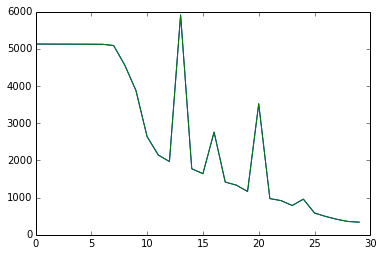

In [155]:
torch_fvals = [s.f for s in torch_steps]
tf_fvals = [s.f for s in tf_steps]
plt.plot(range(30), torch_fvals, range(30), tf_fvals)

## Track down numeric difference

In [37]:
tf.mul??

In [ ]:
config.intra_op_parallelism_threads=1

In [136]:
def replace_none_with_one(l):
    return [(1 if x is None else x) for x in l]

def replace_none_with_zero(l):
    return [(0 if x is None else x) for x in l]

def max_relative_error(vec1, vec2):
    vec1 = np.asarray(vec1)
    vec2 = np.asarray(vec2)
    return np.max(np.abs((vec1-vec2)/vec2))

def plot_err(attr, maxiter=10):
    torch_vals = [s.__dict__[attr] for s in torch_steps[:maxiter]]
    torch_vals = replace_none_with_one(torch_vals)
    tf_vals = [s.__dict__[attr] for s in tf_steps[:maxiter]]
    tf_vals = replace_none_with_one(tf_vals)
    errors = [max_relative_error(ours, theirs) for (ours, theirs) in zip(tf_vals, torch_vals)]
    plt.plot(errors)
    
def plot_val(attr, maxiter=10):
    torch_vals = [s.__dict__[attr] for s in torch_steps[:maxiter]]
    torch_vals = replace_none_with_zero(torch_vals)
    tf_vals = [s.__dict__[attr] for s in tf_steps[:maxiter]]
    tf_vals = replace_none_with_one(tf_vals)
    plt.plot(range(maxiter), tf_vals, range(maxiter), torch_vals)

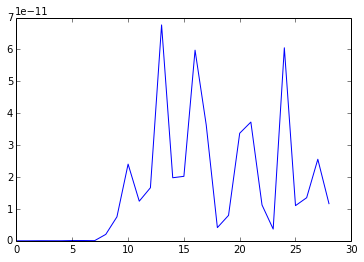

In [162]:
plot_err("f", maxiter=29)

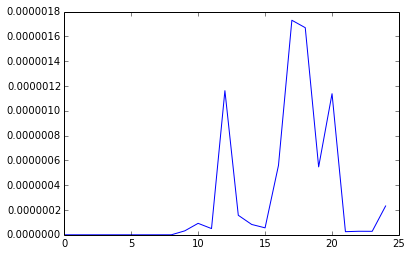

In [160]:
plot_err("x", maxiter=25)

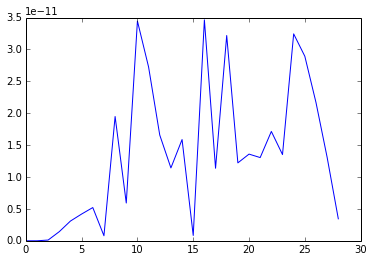

In [163]:
plot_err("gtd", maxiter=29)

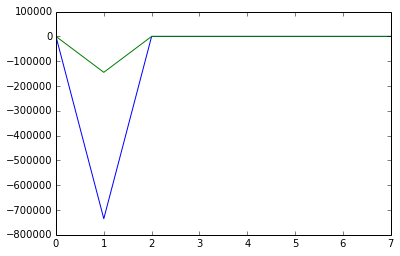

In [137]:
plot_val("gtd", maxiter=8)
maxiter=8
attr="gtd"
torch_vals = [s.__dict__[attr] for s in torch_steps[:maxiter]]
tf_vals = [s.__dict__[attr] for s in tf_steps[:maxiter]]

In [135]:
torch_vals

[None,
 array(-144861.74155),
 array(-3.8607121518003),
 array(-0.47295263596701),
 array(-2.3866259985243),
 array(-1.1953834463466),
 array(-2.0840376235124),
 array(-35.798563286496)]

In [138]:
tf_vals

[None,
 array(-735121.255036311),
 array(-3.911509365600603),
 array(-3.832101471689823),
 array(-3.9681468603053407),
 array(-8.06587434876114),
 array(-0.27889901326496624),
 array(-1.675953391067623)]

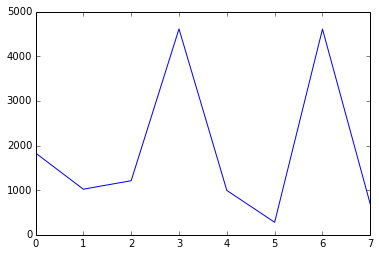

In [139]:
plot_err("g", maxiter=8)

In [140]:
torch_steps[0].g

array([ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.02,  0.99])

In [144]:
torch_steps[0].f

array(5127.302585093)

In [143]:
tf_steps[0].g

array([ 0.99995962,  0.99995962,  0.99995962, ...,  0.912153  ,
        0.93114472,  0.93238423])

In [145]:
max_relative_error(tf_steps[0].x, torch_steps[0].x)

0.000851500466700017

In [148]:
torch_steps[0].x[0]

1.0

In [149]:
tf_steps[0].x[0]

0.99995962156359997

# Power iteration to find rank-1 matrix

In [92]:
def rank1_approximation(a):
    a = a/np.sum(a)
    u = np.sum(a, axis=0, keepdims=True)
    return np.dot(u.T, u)

n = 4
a = np.abs(np.random.random((n, n)))
a = a+a.T
b = a
normdiff = 100
for i in range(10):
    print("Iterating")
    b_old = b
    b = np.dot(b, a)
    b = b/np.sum(b)
    
    normdiff = np.sum(np.abs(b-b_old))
    if normdiff < 1e-10:
        break
        
np.sum(rank1_approximation(b)-b)

Iterating
Iterating
Iterating
Iterating
Iterating
Iterating
Iterating
Iterating
Iterating
Iterating


2.4286128663675299e-16

## Power iteration in tf immediate

In [114]:
env.close()

In [113]:
def rank1_approximation(a):
    a = a/ti.reduce_sum(a)
    u = ti.reduce_sum(a, reduction_indices=[0], keep_dims=True)
    return ti.matmul(ti.transpose(u), u)

n = 2048
a = ti.random_uniform((n, n))
a = a+ti.transpose(a)
b = a
for i in range(10):
    print("Iterating")
    b_old = b
    b = ti.matmul(b, a)
    b = b/ti.reduce_sum(b)
    
    normdiff = ti.reduce_sum(ti.abs(b-b_old))
    if normdiff < 1e-10:
        break
        
ti.reduce_sum(rank1_approximation(b)-b)

ResourceExhaustedError: OOM when allocating tensor with shape[2048,2048]
	 [[Node: Add.float32.op = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Add.float32.0, Add.float32.1)]]
	 [[Node: Add.float32.out.handle/_38 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3_Add.float32.out.handle", tensor_type=DT_STRING, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Add.float32.op', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets-4.2.1-py2.7.egg/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipython-4.2.0-py2.7.egg/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/ipython-4.2.0-py2.7.egg/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/ipython-4.2.0-py2.7.egg/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-98-3bf6f53eef97>", line 1, in <module>
    ti.random_uniform((n, n))
  File "/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/ops/random_ops.py", line 183, in random_uniform
    return math_ops.add(rnd * (maxval - minval), minval, name=name)
  File "/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/ops/gen_math_ops.py", line 70, in add
    result = _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/contrib/immediate/python/immediate/op.py", line 182, in apply_op
    **opdeflib_keywords)
  File "/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


In [108]:
ti.reduce_sum(b, reduction_indices=[0], keep_dims=True)

ITensor([[ 0.23033814  0.23847526  0.35202152  0.17916511]], dtype=float32)

ITensor([[ 0.99608922  0.8692162   0.51664305  0.56585586]
 [ 0.0503422   0.55015564  0.07797253  0.21255088]
 [ 0.90305197  0.11284614  0.72675896  0.55368793]
 [ 0.49552882  0.18307555  0.74828279  0.39706802]], dtype=float32)

In [51]:
u

array([[ 0.72756053,  1.45805939]])

In [52]:
v = np.sum(b, axis=1, keepdims=True)

In [53]:
v

array([[ 0.72395409],
       [ 1.46166583]])

In [55]:
np.dot(v, u) - b

array([[ 0.28572679,  0.5726076 ],
       [ 0.57688346,  1.15609666]])

# Track down performance difference

In [19]:
import tensorflow as tf
from tensorflow.python.client import timeline

import numpy as np
import time

dtype = tf.float32

N=10**5
iters = 10
tf.reset_default_graph()
with tf.device("/cpu:0"):
  arr = tf.ones(N, dtype=dtype)
  arr_handle_op = tf.get_session_handle(tf.identity(arr))
  sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
  arr_handle = sess.run(arr_handle_op)
  holder1, dynamic_arr1 = tf.get_session_tensor(arr_handle.handle, dtype=dtype)
  holder2, dynamic_arr2 = tf.get_session_tensor(arr_handle.handle, dtype=dtype)
  result = tf.get_session_handle(tf.mul(dynamic_arr1, dynamic_arr2))
  result_fetch = tf.group(result)

tf.get_default_graph().finalize()
#run_metadata = tf.RunMetadata()

times = []
for i in range(iters):
  start_time = time.time()
  # collect metadata from last step
  feeds = {holder1: arr_handle.handle, holder2: arr_handle.handle}
  if i == iters-1:
    sess.run(result_fetch, feed_dict=feeds,
             options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE),
             run_metadata=run_metadata)
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)
  else:
    sess.run(result_fetch, feed_dict=feeds)

  end_time = time.time()
  times.append(end_time-start_time)

times = np.asarray(times)*10**6

trace_file = open('timeline.ctf.json', 'w')
trace_file.write(trace.generate_chrome_trace_format())
trace_file.close()

print times

[  1.00496781e+07   4.82797623e+02   3.59058380e+02   3.71932983e+02
   4.01973724e+02   5.43832779e+02   5.20944595e+02   4.22000885e+02
   3.57866287e+02   1.55997276e+03]


In [17]:
run_metadata

step_stats {
  dev_stats {
    device: "/job:localhost/replica:0/task:0/cpu:0"
    node_stats {
      node_name: "_SOURCE"
      all_start_micros: 1466637676271561
      op_start_rel_micros: 1
      op_end_rel_micros: 1
      all_end_rel_micros: 4
      memory {
        allocator_name: "cpu"
      }
      timeline_label: "_SOURCE = NoOp()"
      scheduled_micros: 1466637676271548
    }
    node_stats {
      node_name: "GetSessionTensor"
      all_start_micros: 1466637676271594
      op_start_rel_micros: 1
      op_end_rel_micros: 1
      all_end_rel_micros: 4
      memory {
        allocator_name: "cpu"
      }
      output {
        tensor_description {
          dtype: DT_FLOAT
          shape {
            dim {
              size: 100000
            }
          }
          allocation_description {
            requested_bytes: 400000
            allocator_name: "cpu"
            ptr: 5079703552
          }
        }
      }
      timeline_label: "GetSessionTensor = GetSessionTensor

## Visualize graphs

In [23]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### Visualize persistent Graph

In [28]:
gdef = tf.GraphDef()
from google.protobuf import text_format
text_format.Merge(open("tf_persistent.pbtxt").read(), gdef)
show_graph(gdef)

### Visualize env Graph

In [30]:
gdef = tf.GraphDef()
from google.protobuf import text_format
text_format.Merge(open("tf_env.pbtxt").read(), gdef)
show_graph(gdef)

# Scratch

In [ ]:
device_

In [165]:
import sys
sys.argv

['/Library/Python/2.7/site-packages/ipykernel/__main__.py',
 '-f',
 '/Users/yaroslavvb/Library/Jupyter/runtime/kernel-2660ce9d-7349-4f76-9248-4e38d023fa99.json']

In [4]:
env = immediate.Env(tf)

In [5]:
np.median

AttributeError: 'module' object has no attribute 'median'

In [14]:
env.tf.reshape(env.tf.constant([[1,2,3],[4,5,6]]), [-1])

ITensor([1 2 3 4 5 6], dtype=int32)

In [816]:
a = env.numpy_to_itensor([[1,1],[1,1]], dtype=tf.float64)
b = env.numa
py_to_itensor([[1,1],[1,1]], dtype=tf.float64)
env.tf.abs(a)

ITensor([[ 1.  1.]
 [ 1.  1.]], dtype=float64)

In [34]:
steps[2].x

array([ 0.99993537,  0.99993537,  0.99993537, ...,  0.99993591,
        0.99993463,  0.99993637])

In [821]:
env.tf.div(a, b)

ITensor([[ 1.  1.]
 [ 1.  1.]], dtype=float64)

In [823]:
env.tf.nn.softmax_cross_entropy_with_logits(a, b)

ITensor([ 1.38629436  1.38629436], dtype=float64)

In [119]:
import tensorflow as tf
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(tf.ones((3,3)))

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

In [120]:
config = tf.ConfigProto()

In [ ]:
config.log_device_placement

In [118]:
session.run(tf.ones((3,3)))

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

## Lua-like struct

In [83]:
# inheriting from object adds __dict__ instance
# http://stackoverflow.com/questions/1529002/cant-set-attributes-of-object-class
class dummy(object):
    pass

class Struct(dummy):
    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)
a = Struct()

In [88]:
sess = tf.Session()

In [90]:
sess.graph.as_default().__enter__()

In [33]:
tf.reset_default_graph()
tf.ones(5)

<tf.Tensor 'ones:0' shape=(5,) dtype=float32>

In [34]:
tf.ones((5))

<tf.Tensor 'ones_1:0' shape=(5,) dtype=float32>

In [65]:
a.test4=5

In [66]:
a.values

defaultdict(int, {})

In [35]:
tf.ones??

## Accessing elements question

In [ ]:
import tensorflow as tf
import numpy as np

def assignC():
    C_copy = np.zeros((2,2))
    C = tf.matmul(tf.transpose(x), x)
    C_copy[0,0] = C[0,0]
    #C_copy[0,0] = C[0,0].eval() # error saying "You must feed a value for  placeholder tensor 'Placeholder' with dtype float" at line 17
    print(C_copy[0,0])
    return C_copy

sess = tf.InteractiveSession()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

x = tf.placeholder(tf.float32, [None, 1024])

sess.run(tf.initialize_all_variables())
for i in range(1):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    print(sess.run(tf.identity(assignC()), feed_dict={x: batch_xs}))


In [850]:
tf.reset_default_graph()
C = tf.ones((3,3))

In [854]:
C[0,0]

<tf.Tensor 'Squeeze_2:0' shape=() dtype=float32>

In [852]:
tf.get_default_graph().as_graph_def()

node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 3
          }
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Slice/begin"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\000\000\000\000\000\000"
      }
    }
  }
}
node {
  name: "Slice/size"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\00

## Derivatives

In [814]:
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32)
a = x*x
E = 2*a
(dEda, dEdx) = tf.gradients(E, xs=[a, x])
sess = tf.Session()
sess.run([dEda, dEdx], feed_dict={x: 1})

[2.0, 4.0]

In [810]:
grads

[<tf.Tensor 'gradients/mul_1_grad/Reshape_1:0' shape=() dtype=float32>,
 <tf.Tensor 'gradients/AddN:0' shape=() dtype=float32>]

In [813]:
tf.gradients??

## Tensor shape question

In [449]:
batch_size = tf.shape(tf.ones((10,10)))
print(tf.zeros((batch_size, 128)).get_shape())

ValueError: Shapes (2,) and () are not compatible

In [122]:
a = tf.ones((3,3))

In [123]:
{a:5}

{<tf.Tensor 'ones_6:0' shape=(3, 3) dtype=float32>: 5}

In [124]:
hash(a)

5084961872

In [457]:
asdf=tf.Variable??

In [ ]:
asdf=tf.Variable

In [453]:
print(tf.zeros((batch_size, 128)).get_shape())

(?, ?)


In [27]:
import tensorflow as tf
nInputs = 6
nUnitsLayer1 = 3
weights = tf.Variable(tf.truncated_normal([nInputs, nUnitsLayer1]))
biases= tf.Variable(tf.zeros(nUnitsLayer1))

print 'nInputs', nInputs
print 'nUnitsLayer1', nUnitsLayer1
print 'weights shape', tf.shape(weights)
print 'biases shape', tf.shape(biases)

init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    print 'weights'
    print (weights.eval())
    print 'biases'
    print (biases.eval())


nInputs 6
nUnitsLayer1 3
weights shape Tensor("Shape:0", shape=(2,), dtype=int32)
biases shape Tensor("Shape_1:0", shape=(1,), dtype=int32)
weights
[[-0.42564794  1.32690036 -0.57812071]
 [ 1.3026278  -1.29796839 -1.02938724]
 [ 0.19238499  1.10781586 -0.24808854]
 [-0.60994369 -0.30048054  0.5742262 ]
 [ 0.13138418 -0.60150367  0.44378978]
 [ 0.42674765 -0.44903693  0.32681581]]
biases
[ 0.  0.  0.]


In [28]:
weights.get_shape()

TensorShape([Dimension(6), Dimension(3)])

In [29]:
weights

In [31]:
tf.shape(weights).get_shape

TensorShape([Dimension(2)])

In [163]:
tf.group(tf.constant(1))

In [164]:
stf.nn.top_k([1,2,3])

TopKV2(values=<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>, indices=<tf.Tensor 'TopKV2:1' shape=(1,) dtype=int32>)

In [166]:
tf.split(0, 2, [1,2])

[<tf.Tensor 'split:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'split:1' shape=(1,) dtype=int32>]

In [168]:
tf.reset_default_graph()
sess.run(tf.nn.top_k([1,2,3]))

ValueError: Fetch argument <tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32> of <tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32> cannot be interpreted as a Tensor. (Tensor Tensor("TopKV2:0", shape=(1,), dtype=int32) is not an element of this graph.)

In [176]:
tf.reset_default_graph()
op = tf.nn.top_k([1,2,3])
sess = tf.Session()

In [177]:
tf.get_default_graph().as_graph_def()

node {
  name: "TopKV2/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
node {
  name: "TopKV2/k"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
node {
  name: "TopKV2"
  op: "TopKV2"
  input: "TopKV2/input"
  input: "TopKV2/k"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "sorted"
    value {
      b: true
    }
  }
}
versions {
  producer: 10
}

In [179]:
sess.run(["TopKV2:0"])

[array([3], dtype=int32)]

In [181]:
tf.reset_default_graph()
op = tf.split(0, 2, [1,2])
sess = tf.Session()

In [182]:
tf.get_default_graph().as_graph_def()

node {
  name: "split/split_dim"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 0
      }
    }
  }
}
node {
  name: "split/value"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000"
      }
    }
  }
}
node {
  name: "split"
  op: "Split"
  input: "split/split_dim"
  input: "split/value"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "num_split"
    value {
      i: 2
    }
  }
}
versions {
  producer: 10
}

In [184]:
sess.run("split:1")

array([2], dtype=int32)

In [185]:
op

[<tf.Tensor 'split:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'split:1' shape=(1,) dtype=int32>]

In [193]:
tf.reset_default_graph()
op = tf.nn.top_k([1,2,3])
sess = tf.InteractiveSession()
sess.run(tf.nn.top_k([1,2,3]))

[array([3], dtype=int32), array([2], dtype=int32)]

In [197]:
op[0]

<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>

In [205]:
op.values

<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>

In [206]:
op = tf.split(0,3, [1,2,3])

In [208]:
tf.get_default_graph().as_graph_def()

node {
  name: "TopKV2/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
node {
  name: "TopKV2/k"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
node {
  name: "TopKV2"
  op: "TopKV2"
  input: "TopKV2/input"
  input: "TopKV2/k"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "sorted"
    value {
      b: true
    }
  }
}
node {
  name: "TopKV2_1/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tens

In [213]:
tf.reset_default_graph()
a = tf.Variable(tf.ones_initializer((3,3)))
init_op = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init_op)
print(tf.get_default_graph().as_graph_def())
print sess.run(["Variable:0"])

node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 3
          }
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Variable"
  op: "Variable"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 3
        }
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "Variable/Assign"
  op: "Assign"
  input: "Variable"
  input: "ones"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@Variable"
      }
    }
  }
  

In [215]:
print sess.run(["Variable:0"])

[array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)]


In [216]:
tf.reset_default_graph()
tf.constant(1)
print(tf.get_default_graph().as_graph_def())


node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
versions {
  producer: 10
}



In [219]:
    tf.reset_default_graph()
    value = tf.constant(1)
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()


node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
versions {
  producer: 10
}



In [222]:
sess.run("Const:0")

1

In [232]:
    tf.reset_default_graph()
    value = tf.Variable(tf.ones_initializer(()))
    value2 = value+3
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()
    sess.run(tf.initialize_all_variables())


node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Variable"
  op: "Variable"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "Variable/Assign"
  op: "Assign"
  input: "Variable"
  input: "ones"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@Variable"
      }
    }
  }
  attr {
    key: "use_locking"
    value {
      b: true
    }
  }
  attr {
    key: "validate_shape"
    value {
      b: true
    }
  }
}
node {
  name: "Variable/read"
  op: "Ide

In [227]:
type(value)

tensorflow.python.ops.variables.Variable

In [228]:
value.name

u'Variable:0'

In [233]:
sess.run("Variable:0")

1.0

In [236]:
    tf.reset_default_graph()
    value = tf.placeholder(tf.uint8)
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()
    sess.run(tf.identity(value), feed_dict={"Placeholder:0":2})


node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_UINT8
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
versions {
  producer: 10
}



Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x12aadfb90>> ignored


2

In [235]:
value

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=uint8>

In [593]:
tf.FIFOQueue(1000, )

In [596]:
tf.train.Saver??

In [595]:
a.save??

In [607]:
tf.reset_default_graph()
a = tf.ones((3,3))
b = tf.ones((3,3))
a.__add__(b)

<tf.Tensor 'add:0' shape=(3, 3) dtype=float32>

In [609]:
method=a.__add__

In [610]:
method??

In [604]:
a+b

<tf.Tensor 'add_7:0' shape=(3, 3) dtype=float32>

In [606]:
a.__add__??

In [611]:
dir(a)

['OVERLOADABLE_OPERATORS',
 '__abs__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',
 '_as_node_def_input',
 '_consumers',
 '_dtype',
 '_op',
 '_override_operator',
 '_shape',
 '_shape_as_list',
 '_value_index',
 'consumers',
 'device',
 'dtype',
 'eval',
 'get_shape',
 'graph',
 'name',
 'op',
 'set_sh

In [612]:
a.OVERLOADABLE_OPERATORS

{'__abs__',
 '__add__',
 '__and__',
 '__div__',
 '__floordiv__',
 '__ge__',
 '__getitem__',
 '__gt__',
 '__invert__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__neg__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__sub__',
 '__truediv__',
 '__xor__'}

In [615]:
func_mod = tf.Tensor.__mod__

In [617]:
func_mod??

In [619]:
tf.reset_default_graph()
dtype = tf.int32
a = tf.placeholder(dtype)
b = tf.placeholder(dtype)
c = a+b

In [620]:
c

<tf.Tensor 'add:0' shape=<unknown> dtype=int32>

In [643]:
tf.reset_default_graph()
dtype = tf.int32
a = tf.placeholder(dtype)
b = tf.placeholder(dtype)
c = tf.add(a, b)

In [644]:
tf.get_default_graph().as_graph_def()

node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "Placeholder_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "Add"
  op: "Add"
  input: "Placeholder"
  input: "Placeholder_1"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
versions {
  producer: 10
}

In [624]:
import inspect

In [625]:
inspect.getsource(a.__add__)

'def to_bfloat16(x, name="ToBFloat16"):\n  """Casts a tensor to type `bfloat16`.\n\n  Args:\n    x: A `Tensor` or `SparseTensor`.\n    name: A name for the operation (optional).\n\n  Returns:\n    A `Tensor` or `SparseTensor` with same shape as `x` with type `bfloat16`.\n\n  Raises:\n    TypeError: If `x` cannot be cast to the `bfloat16`.\n  """\n  return cast(x, dtypes.bfloat16, name=name)\n'

In [626]:
inspect.getfile(a.__add__)

'/Users/yaroslavvb/tfimmediate_hood/tensorflow/_python_build/tensorflow/python/ops/math_ops.py'

In [627]:
type(a.__add__)

instancemethod

In [629]:
type(tf.Tensor.__add__)

instancemethod

In [630]:
inspect.getsource(tf.Tensor.__add__)

'def to_bfloat16(x, name="ToBFloat16"):\n  """Casts a tensor to type `bfloat16`.\n\n  Args:\n    x: A `Tensor` or `SparseTensor`.\n    name: A name for the operation (optional).\n\n  Returns:\n    A `Tensor` or `SparseTensor` with same shape as `x` with type `bfloat16`.\n\n  Raises:\n    TypeError: If `x` cannot be cast to the `bfloat16`.\n  """\n  return cast(x, dtypes.bfloat16, name=name)\n'

In [631]:
stuff = tf.Tensor.__add__

In [633]:
stuff.im_func.func_closure

(<cell at 0x125687868: function object at 0x1254f7d70>,
 <cell at 0x1256878a0: str object at 0x10c0ac0a8>)

In [637]:
real_function = tf.Tensor.__add__.im_func.func_closure[0].cell_contents

In [654]:
tf.add.__module__ + "." + tf.add.__name__

'tensorflow.python.ops.gen_math_ops.add'

In [642]:
tf.add

<function tensorflow.python.ops.gen_math_ops.add>

In [655]:
tf.Tensor.OVERLOADABLE_OPERATORS

{'__abs__',
 '__add__',
 '__and__',
 '__div__',
 '__floordiv__',
 '__ge__',
 '__getitem__',
 '__gt__',
 '__invert__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__neg__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__sub__',
 '__truediv__',
 '__xor__'}

In [1050]:
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 bus_adjacency: BUS_ANY
 incarnation: 12496753478763930059]

In [664]:
input_tensor = tf.placeholder(tf.float32, [None, 32])
batch_size = tf.shape(input_tensor)[0]

res = tf.zeros((5, 128))
print res.get_shape()  # prints (?, ?) WHEREAS one could expect (?, 128)

res.set_shape([None, 128])
print res.get_shape()  # prints (?, 128)

(5, 128)
(5, 128)


In [845]:
tf.add.__globals__["_op_def_lib"]._ops["Add"].op_def

name: "Add"
input_arg {
  name: "x"
  type_attr: "T"
}
input_arg {
  name: "y"
  type_attr: "T"
}
output_arg {
  name: "z"
  type_attr: "T"
}
attr {
  name: "T"
  type: "type"
  allowed_values {
    list {
      type: DT_HALF
      type: DT_FLOAT
      type: DT_DOUBLE
      type: DT_UINT8
      type: DT_INT8
      type: DT_INT16
      type: DT_INT32
      type: DT_INT64
      type: DT_COMPLEX64
      type: DT_COMPLEX128
      type: DT_STRING
    }
  }
}

In [12]:
tf.placeholder_with_default??

In [4]:
env = immediate.Env(tf)

In [5]:
im = env.tf
val1 = im.ones((3,))             # creates tensor on GPU
val2 = val1 + val1                # runs into tf.add, keeps result on GPU
val3 = im.ones((2, 2, 2, 2))
val4 = im.nn.conv2d(val3, val3, [1, 1, 1, 1], "VALID")   # run CuDNN conv2d
if (im.reduce_sum(val3)>0.):     # runs reduce_sum on GPU, transfers bool to CPU
  print(val4)                     # transfers whole tensor to CPU for display


ITensor([[[[ 8.  8.]]]


 [[[ 8.  8.]]]], dtype=float32)


In [6]:
2+3

5

In [7]:
env.tf.reshape??

In [8]:
tf.slice??